In [1]:
import numpy as np
import pandas as pd
from tabulate import tabulate
import re
import warnings

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from skopt import BayesSearchCV
import pickle

In [2]:
warnings.filterwarnings(action="ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 1.0. Data Reading and Cleaning

In [3]:
dataset = './data/tabela-fipe-historico-precos.csv'
df_raw = pd.read_csv(dataset)

In [4]:
df_raw.head()

,Unnamed: 0,codigoFipe,marca,modelo,anoModelo,mesReferencia,anoReferencia,valor
0,0,038003-2,Acura,Integra GS 1.8,1992,11,2016,13041.0
1,1,038001-6,Acura,NSX 3.0,1995,3,2013,52339.0
2,2,038003-2,Acura,Integra GS 1.8,1992,3,2018,12423.0
3,3,038002-4,Acura,Legend 3.2/3.5,1998,5,2016,31067.0
4,4,038002-4,Acura,Legend 3.2/3.5,1998,2,2019,26381.0


In [5]:
df_raw.shape

(466020, 8)

In [6]:
df_raw.columns

Index(['Unnamed: 0', 'codigoFipe', 'marca', 'modelo', 'anoModelo',
       'mesReferencia', 'anoReferencia', 'valor'],
      dtype='object')

In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466020 entries, 0 to 466019
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     466020 non-null  int64  
 1   codigoFipe     466020 non-null  object 
 2   marca          466020 non-null  object 
 3   modelo         466020 non-null  object 
 4   anoModelo      466020 non-null  int64  
 5   mesReferencia  466020 non-null  int64  
 6   anoReferencia  466020 non-null  int64  
 7   valor          466020 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 28.4+ MB


<Axes: ylabel='Frequency'>

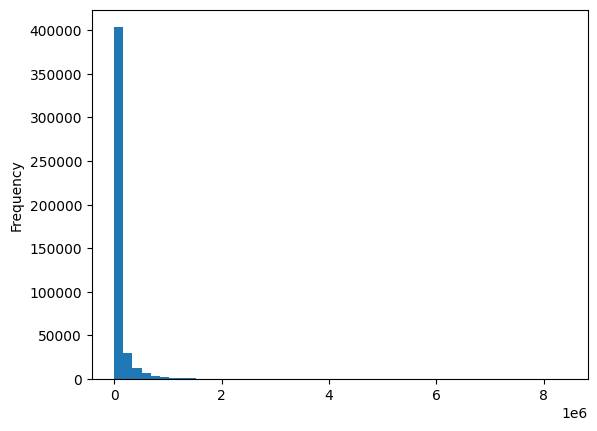

In [8]:
df_raw['valor'].plot(kind='hist', bins = 50)

## 1.1. Data Cleaning

In [9]:
df1 = df_raw.copy()
df1.shape

(466020, 8)

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466020 entries, 0 to 466019
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     466020 non-null  int64  
 1   codigoFipe     466020 non-null  object 
 2   marca          466020 non-null  object 
 3   modelo         466020 non-null  object 
 4   anoModelo      466020 non-null  int64  
 5   mesReferencia  466020 non-null  int64  
 6   anoReferencia  466020 non-null  int64  
 7   valor          466020 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 28.4+ MB


In [11]:
def snake_case(c):
    return re.sub(r'(?<!^)(?=[A-Z])', '_', c).lower()
df1.columns = [snake_case(c) for c in df1.columns]

categorical_columns = list(df1.dtypes[df1.dtypes == 'object'].index)
for c in categorical_columns:
    df1[c] = df1[c].str.lower().str.replace(' ', '_')
    df1[c] = df1[c].str.replace('-','_')

df1['codigo_fipe'] = df1['codigo_fipe'].str.replace('-','')

In [12]:
# couldn't figure out how to not import this column while reading the dataset
df1.drop(columns=['unnamed: 0'], inplace=True)

### 1.1.1. Checking Data Types

In [13]:
df1.dtypes

codigo_fipe        object
marca              object
modelo             object
ano_modelo          int64
mes_referencia      int64
ano_referencia      int64
valor             float64
dtype: object

In [14]:
df1['codigo_fipe'] = df1['codigo_fipe'].astype('int64')

In [15]:
df1.dtypes

codigo_fipe         int64
marca              object
modelo             object
ano_modelo          int64
mes_referencia      int64
ano_referencia      int64
valor             float64
dtype: object

### 1.1.2. Checking for Missing Values

In [16]:
df1.isna().sum()

codigo_fipe       0
marca             0
modelo            0
ano_modelo        0
mes_referencia    0
ano_referencia    0
valor             0
dtype: int64

### 1.1.3. Checking for Duplicated Values

In [17]:
df1.duplicated().sum()

0

# 2.0. Feature Engineering

In [18]:
df2 = df1.copy()

In [19]:
media_por_marca = df2.groupby('marca')['valor'].mean()

df2['classificacao_marca'] = df2['marca'].map(
        lambda marca: (
        'economical' if media_por_marca[marca] <= 50_000 else
        'affordable' if media_por_marca[marca] <= 100_000 else
        'mid_range' if media_por_marca[marca] <= 500_000 else
        'luxury' if media_por_marca[marca] <= 1_000_000 else
        'super_luxury' if media_por_marca[marca] <= 5_000_000 else
        'ultra_luxury'
    )
)



## 2.2. Spliting Data

In [20]:
df_full_train, df_test = train_test_split(df2, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [21]:
len(df_train), len(df_val), len(df_test)

(279612, 93204, 93204)

In [22]:
X_train = df_train.reset_index(drop=True)
X_val = df_val.reset_index(drop=True)
X_test = df_test.reset_index(drop=True)

In [23]:
y_train = X_train.valor.values
y_val = X_val.valor.values
y_test = X_test.valor.values

In [24]:
X_train.drop(columns=['valor'], inplace=True)
X_val.drop(columns=['valor'], inplace=True)
X_test.drop(columns=['valor'], inplace=True)

# 3.0. Feature Selection

In [25]:
freq_encoding_map = X_train['marca'].value_counts() / len(X_train)
X_train['marca_freq_encoded'] = X_train['marca'].map(freq_encoding_map)
X_val['marca_freq_encoded'] = X_val['marca'].map(freq_encoding_map)
X_test['marca_freq_encoded'] = X_test['marca'].map(freq_encoding_map)

X_train = pd.get_dummies(X_train, columns=['classificacao_marca'], drop_first=True)
X_val = pd.get_dummies(X_val, columns=['classificacao_marca'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['classificacao_marca'], drop_first=True)

In [26]:
categorical_cols = ['marca_freq_encoded'] + [col for col in X_train.columns if col.startswith('classificacao_marca')]
numerical_cols = ['codigo_fipe', 'ano_modelo', 'ano_referencia', 'mes_referencia']

# 5.0. Training Models

In [27]:
def ml_error_to_df(model_name, model, X, y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())  # turning neg mse into rmse

    result_df = pd.DataFrame({
        "Model Name": [model_name],
        "MAE": [mae],
        "MAPE": [mape],
        "RMSE": [rmse],
        "CV RMSE": [cv_rmse]
    })

    return result_df


## 5.1. Ensemble Learning Models

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', 'passthrough', categorical_cols)
    ]
)

### 5.1.1. Random Forest

In [29]:
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['codigo_fipe', 'ano_modelo',
                                                   'ano_referencia',
                                                   'mes_referencia']),
                                                 ('cat', 'passthrough',
                                                  ['marca_freq_encoded',
                                                   'classificacao_marca_economical',
                                                   'classificacao_marca_luxury',
                                                   'classificacao_marca_mid_range',
                                                   'classificacao_marca_super_luxury'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [30]:
y_pred_rf = pipeline_rf.predict(X_test)

In [31]:
error_rf = ml_error_to_df("Random Forest", pipeline_rf, X_test, y_test, y_pred_rf)
error_rf


,Model Name,MAE,MAPE,RMSE,CV RMSE
0,Random Forest,2380.425632,0.016924,18794.762568,55671.008432


### 5.1.2. LightGBM

In [32]:
pipeline_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(random_state=42, metric='rmse', force_row_wise=True))
])

In [33]:
pipeline_lgb.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 279612, number of used features: 9
[LightGBM] [Info] Start training from score 116098.476031


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['codigo_fipe', 'ano_modelo',
                                                   'ano_referencia',
                                                   'mes_referencia']),
                                                 ('cat', 'passthrough',
                                                  ['marca_freq_encoded',
                                                   'classificacao_marca_economical',
                                                   'classificacao_marca_luxury',
                                                   'classificacao_marca_mid_range',
                                                   'classificacao_marca_super_luxury'])])),
                ('regressor',
                 LGBMRegressor(force_row_wise=True, metric='rmse',
                               random_state=42))])

In [34]:
y_pred_lgb = pipeline_lgb.predict(X_test)

In [35]:
error_lgb = ml_error_to_df("LightGBM", pipeline_lgb, X_test, y_test, y_pred_lgb)
error_lgb

[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 74563, number of used features: 9
[LightGBM] [Info] Start training from score 116044.950445
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 74563, number of used features: 9
[LightGBM] [Info] Start training from score 114851.834543
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 74563, number of used features: 9
[LightGBM] [Info] Start training from score 115010.153642
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 74563, number of used features: 9
[LightGBM] [Info] Start training from score 115227.946421
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 74564, number of used features: 9
[LightGBM] [Info] Start training from score 116239.149590


,Model Name,MAE,MAPE,RMSE,CV RMSE
0,LightGBM,32563.304135,0.362859,103413.367567,104720.607268


### 5.1.3. CatBoost

In [36]:
pipeline_catboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        random_state=42,
        loss_function='RMSE',
        verbose=100
    ))
])

In [37]:

pipeline_catboost.fit(X_test, y_test)

0:	learn: 317395.3906418	total: 50.9ms	remaining: 50.9s
100:	learn: 111715.6302051	total: 414ms	remaining: 3.68s
200:	learn: 105559.0478671	total: 767ms	remaining: 3.05s
300:	learn: 102609.1451773	total: 1.12s	remaining: 2.59s
400:	learn: 100529.6868341	total: 1.47s	remaining: 2.19s
500:	learn: 98844.1149751	total: 1.88s	remaining: 1.87s
600:	learn: 97130.5082284	total: 2.34s	remaining: 1.55s
700:	learn: 95856.5793650	total: 2.83s	remaining: 1.21s
800:	learn: 94998.1692671	total: 3.26s	remaining: 810ms
900:	learn: 94206.2539071	total: 3.69s	remaining: 405ms
999:	learn: 93304.9910892	total: 4.11s	remaining: 0us


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['codigo_fipe', 'ano_modelo',
                                                   'ano_referencia',
                                                   'mes_referencia']),
                                                 ('cat', 'passthrough',
                                                  ['marca_freq_encoded',
                                                   'classificacao_marca_economical',
                                                   'classificacao_marca_luxury',
                                                   'classificacao_marca_mid_range',
                                                   'classificacao_marca_super_luxury'])])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x70a033217c10>)])

In [38]:
y_pred_catboost = pipeline_catboost.predict(X_test)

In [39]:
error_catboost = ml_error_to_df("Catboost", pipeline_catboost, X_test, y_test, y_pred_catboost)
error_catboost

0:	learn: 320596.2762480	total: 3.66ms	remaining: 3.66s
100:	learn: 114134.5075095	total: 351ms	remaining: 3.12s
200:	learn: 107094.0444140	total: 702ms	remaining: 2.79s
300:	learn: 103723.8900463	total: 1.06s	remaining: 2.45s
400:	learn: 101409.6833643	total: 1.41s	remaining: 2.11s
500:	learn: 99655.3900565	total: 1.77s	remaining: 1.77s
600:	learn: 98132.1822476	total: 2.15s	remaining: 1.43s
700:	learn: 96880.5152605	total: 2.53s	remaining: 1.08s
800:	learn: 95659.2904796	total: 2.92s	remaining: 725ms
900:	learn: 94715.0425738	total: 3.28s	remaining: 360ms
999:	learn: 93799.3213066	total: 3.63s	remaining: 0us
0:	learn: 313636.5740412	total: 3.35ms	remaining: 3.34s
100:	learn: 110247.6665195	total: 331ms	remaining: 2.95s
200:	learn: 103736.6622861	total: 684ms	remaining: 2.72s
300:	learn: 100081.7862663	total: 1.04s	remaining: 2.41s
400:	learn: 97414.1437978	total: 1.39s	remaining: 2.08s
500:	learn: 95387.5825555	total: 1.75s	remaining: 1.74s
600:	learn: 93519.1584111	total: 2.1s	remai

,Model Name,MAE,MAPE,RMSE,CV RMSE
0,Catboost,30836.687189,0.33956,93304.991089,103928.998768


In [40]:
error_final = pd.concat([error_rf, error_lgb, error_catboost]).reset_index(drop=True)
error_final

,Model Name,MAE,MAPE,RMSE,CV RMSE
0,Random Forest,2380.425632,0.016924,18794.762568,55671.008432
1,LightGBM,32563.304135,0.362859,103413.367567,104720.607268
2,Catboost,30836.687189,0.339560,93304.991089,103928.998768


# 6.0. Model Tuning

In [ ]:
param_grid = {
    'regressor__n_estimators': [100, 500],
    'regressor__min_samples_split': [2, 20],
    'regressor__min_samples_leaf': [1, 10]
}

bayes_search = BayesSearchCV(
    estimator=pipeline_rf,
    search_spaces=param_grid,
    n_iter=32,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    verbose=2
)


In [43]:
bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END regressor__min_samples_leaf=5, regressor__min_samples_split=15, regressor__n_estimators=473; total time= 2.6min
[CV] END regressor__min_samples_leaf=5, regressor__min_samples_split=15, regressor__n_estimators=473; total time= 2.6min
[CV] END regressor__min_samples_leaf=5, regressor__min_samples_split=15, regressor__n_estimators=473; total time= 2.6min
[CV] END regressor__min_samples_leaf=5, regressor__min_samples_split=15, regressor__n_estimators=473; total time= 2.6min
[CV] END regressor__min_samples_leaf=5, regressor__min_samples_split=15, regressor__n_estimators=473; total time= 2.6min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END regressor__min_samples_leaf=9, regressor__min_samples_split=18, regressor__n_estimators=221; total time= 1.2min
[CV] END regressor__min_samples_leaf=9, regressor__min_samples_split=18, regressor__n_estimators=221; total time= 1.2min
[CV] END regressor__min_samples_lea

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          'passthrough',
                                                                          ['codigo_fipe',
                                                                           'ano_modelo',
                                                                           'ano_referencia',
                                                                           'mes_referencia']),
                                                                         ('cat',
                                                                          'passthrough',
                                                                          ['marca_freq_encoded',
                                                                           'classificacao_marca_economical',
                                                                           'classificacao_marca_luxury',
                                                                           'classificacao_marca_mid_range',
                                                                           'classificacao_marca_super_luxury'])])),
                                        ('regressor',
                                         RandomForestRegressor(random_state=42))]),
              n_iter=32, random_state=42, scoring='neg_root_mean_squared_error',
              search_spaces={'regressor__min_samples_leaf': [1, 10],
                             'regressor__min_samples_split': [2, 20],
                             'regressor__n_estimators': [100, 500]},
              verbose=2)

In [44]:
best_model = bayes_search.best_estimator_
best_params = bayes_search.best_params_
best_score = -bayes_search.best_score_ 

In [45]:
print("Best Parameters:", best_params)
print("Best RMSE on CV:", np.sqrt(best_score))

Best Parameters: OrderedDict([('regressor__min_samples_leaf', 1), ('regressor__min_samples_split', 2), ('regressor__n_estimators', 500)])
Best RMSE on CV: 138.89831082719076


# 7.0. Model Serving

In [ ]:
with open('./models/random_forest_model_with_preprocessing.pkl', 'wb') as f:
    pickle.dump(bayes_search.best_estimator_, f)